In [1]:
import random
import copy
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm

from utils import test_agent, plot_stats

# Create and prepare the environment

### Create the environment

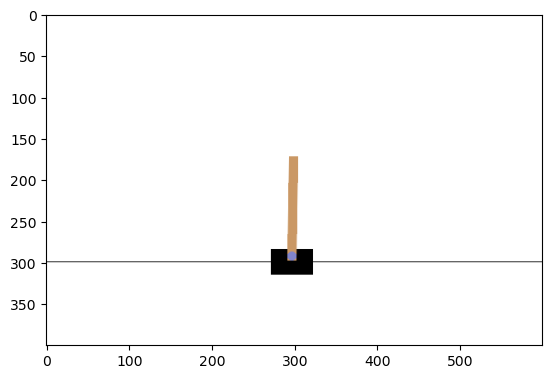

In [3]:
env = gym.make("CartPole-v1")
env.reset()
plt.imshow(env.render(mode="rgb_array"))

In [4]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f"MountainCar env: State dimenstions: {state_dims}, Number of actions: {num_actions}")

MountainCar env: State dimenstions: 4, Number of actions: 2


### Prepare the environment to work with PyTorch

In [5]:
class PreprocessEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def reset(self):
        state = self.env.reset()

        # [0. 0.] -> [[0. 0.]]
        return torch.from_numpy(state).unsqueeze(dim=0).float()

    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)

        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)

        return next_state, reward, done, info

In [6]:
env = PreprocessEnv(env)

In [7]:
state = env.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env.step(action)
print(f"Sample state: {state}")
print(f"Next state: {next_state}, Reward: {reward}, Done: {done}")

Sample state: tensor([[ 0.0120, -0.0364,  0.0147,  0.0211]])
Next state: tensor([[ 0.0113, -0.2317,  0.0151,  0.3184]]), Reward: tensor([[1.]]), Done: tensor([[False]])


### Create the Q-Netework

In [20]:
q_network = nn.Sequential(
    nn.Linear(state_dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions),
)

### Create the target Q-Network

In [21]:
target_q_network = copy.deepcopy(q_network).eval()

### Create the exploratory policy

In [10]:
def policy(state, epsilon=0.):    
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

In [25]:
def target_policy(state):
    av = target_q_network(state).detach()
    return torch.argmax(av, dim=-1, keepdim=True)

### Create the Experience Replay buffer

In [11]:
class ReplayMemory:

    def __init__(self, capacity=1000000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

# Implementat the algorithm

In [12]:
def deep_q_learning(q_network, policy, episodes,
                    alpha=0.0001, batch_size=32, gamma=0.99, epsilon=0.2):

    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory()
    stats = {'MSE Loss': [], 'Returns': []}

    for episode in tqdm(range(1, episodes + 1)):
        state = env.reset()
        done = False
        ep_return = 0
        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)

            memory.insert([state, action, reward, done, next_state])

            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
                qsa_b = q_network(state_b).gather(1, action_b)

                next_qsa_b = target_q_network(next_state_b)
                next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0]

                target_b = reward_b + ~done_b * gamma * next_qsa_b
                loss = F.mse_loss(qsa_b, target_b)
                q_network.zero_grad()
                loss.backward()
                optim.step()

                stats['MSE Loss'].append(loss.item())

            state = next_state
            ep_return += reward.item()


        stats['Returns'].append(ep_return)

        if episode % 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict())

    return stats

In [22]:
stats = deep_q_learning(q_network, policy, 1000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:53<00:00,  8.83it/s]


# Show results

### Plot execution stats

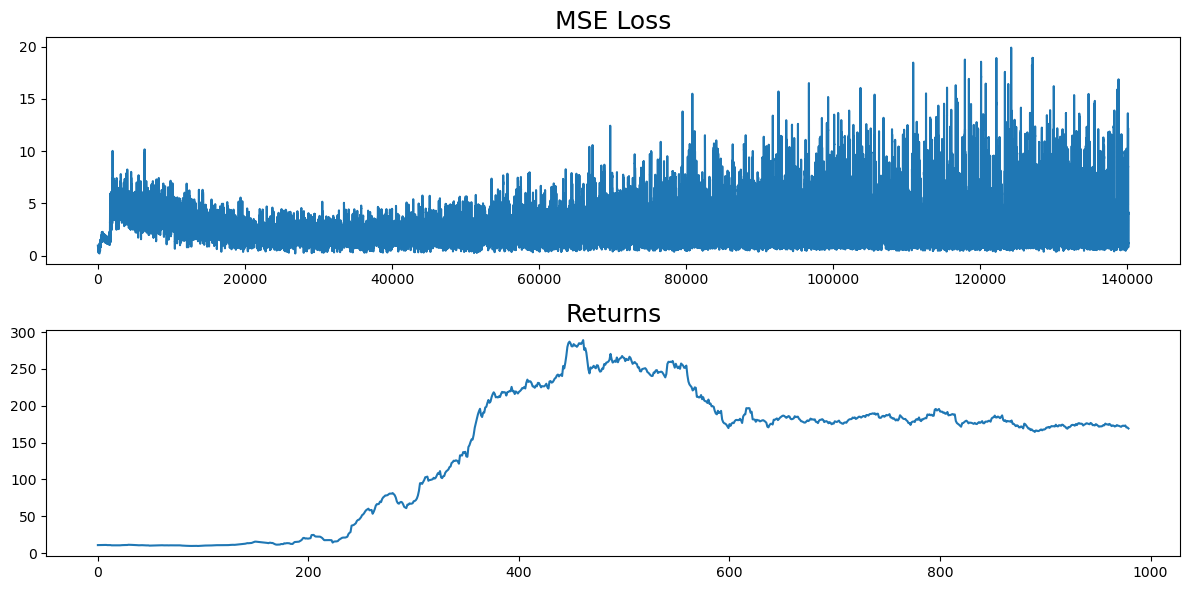

In [23]:
plot_stats(stats)

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

In [ ]:
plot_cost_to_go(env, q_network, xlabel='Car Position', ylabel='Velocity')

### Show resulting policy: $\pi(s)$

In [ ]:
plot_max_q(env, q_network, xlabel='Car Position', ylabel='Velocity',
           action_labels=['Back', 'Do nothing', 'Forward'])

### Test the result agent

In [26]:
test_agent(env, target_policy, episodes=2)